# Context

Projects have a fixed amount of time/effort available to improve the retrieval pipeline, so you need to prioritize where you spend your effort. You'll want to spend effort on improvements that
1. Affect many queries
2. Affect queries with room for improvement
3. Affect high value queries

This notebook shows how to monitor production traffic and identify what areas to improve (focusing on criteria 1 and 2 above).

Specifically, we use an LLM to categorize queries into different topics or functionality areas. We can do basic analytics to detect
1. Which categories have many queries
2. Which categories have measures of low customer satisfaction

We could do further analytics to look at how these stats change over time (e.g. as we bring in new types of users).

## Load Data

In [1]:
import asyncio
from typing import List
import instructor
import json
from openai import AsyncOpenAI
import pandas as pd

from question_types import (
    UntypedQuestion,
    TypedQuestion,
    Question,
    Product,
    QuestionTypes,
    question_type_details,
)

client = instructor.from_openai(AsyncOpenAI())

def read_to_question(q: dict) -> UntypedQuestion:
    question = Question(text=q["question"])
    product = Product(title=q["product"]["title"], description=q["product"]["description"])
    return UntypedQuestion(question=question, product=product, thumbs_up=q["thumbs_up"], days_ago=q["days_ago"])

with open("prod_questions.json", "r") as f:
    prod_questions = json.load(f)
    untyped_questions = [read_to_question(q) for q in prod_questions]

prod_questions[:3]

[{'question': 'How does this cordless drill compare in weight to the ProTech 2200?',
  'product': {'title': 'Cordless Drill',
   'description': 'This powerful cordless drill features a lightweight design for easy handling and comes with two speed settings for various drilling applications. Its ergonomic grip allows for extended use without discomfort, making it perfect for both DIY enthusiasts and professionals.'},
  'thumbs_up': False,
  'days_ago': 15},
 {'question': 'Is the power output of this drill higher than the DrillMaster X1?',
  'product': {'title': 'Cordless Drill',
   'description': 'This powerful cordless drill features a lightweight design for easy handling and comes with two speed settings for various drilling applications. Its ergonomic grip allows for extended use without discomfort, making it perfect for both DIY enthusiasts and professionals.'},
  'thumbs_up': False,
  'days_ago': 10},
 {'question': 'Does this model have better battery life than the EcoDrill 300?',
 

# Classifying Queries

The raw query types are defined in `question_types.py`. We include these in our prompt and ask an LLM to categorize each question. We could either categorize each question into a single category or into multiple categories. This example categorizes into a single category.

In [2]:
from pydantic import BaseModel

# Specify a response model that facilitates chain of thought reasoning
class QuestionTypeResponse(BaseModel):
    reasoning: str
    question_type: QuestionTypes
    

In [3]:
async_client = instructor.from_openai(AsyncOpenAI())

q_type_explanation_list = [
    f"NAME: {q.title}\nDESCRIPTION: {q.description}\nEXAMPLES: `{q.examples[0]}`\n`{q.examples[1]}`"
    for q in question_type_details.values()
]

q_type_explanation_str = "\n---\n".join(q_type_explanation_list)


async def categorize_question(
    question: UntypedQuestion, semaphore: asyncio.Semaphore = asyncio.Semaphore(1)
) -> TypedQuestion:
    async with semaphore:
        question_text = question.question.text
        prompt = f"""
        Classify the attached question into one of the following categories:
        {', '.join([q.value for q in QuestionTypes])}

        Here are descriptions of each category:
        {q_type_explanation_str}

        Here is the question:
        Question: {question_text}

        For your context, here the product is on a hardware store website with the following description:
        {question.product.description}

        Your response should start with step-by-step reasoning for why the question belongs in any particular category.
        Then respond with the category name you determine is the best fit.
        """

        try:
            result = await async_client.chat.completions.create(
                model="gpt-4o-mini",
                response_model=QuestionTypeResponse,
                messages=[{"role": "user", "content": prompt}],
            )
            question_type = QuestionTypes(result.question_type)

            return TypedQuestion(
                question=question.question,
                question_type=question_type,
                product=question.product,
                thumbs_up=question.thumbs_up,
                days_ago=question.days_ago,
            )
        except Exception as e:
            print(f"Error classifying question: {str(e)}")
            return None

Run this for all questions (using async patterns since we have many questions, and our time will be spent primarily waiting for API responses).

In [4]:

async def categorize_questions(max_concurrency: int = 100) -> List[TypedQuestion]:
    out = []
    semaphore = asyncio.Semaphore(max_concurrency)
    tasks = [categorize_question(o, semaphore) for o in untyped_questions]
    categorized_questions = await asyncio.gather(*tasks, return_exceptions=True)
    for cq in categorized_questions:
        if not isinstance(cq, Exception):
            out.append(cq)
        else:
            print(f"Error categorizing question: {str(cq)}")
    return out


categorized_questions = await categorize_questions()

# Analytics

Convert the data into a DataFrame and calculate basic statistics

In [5]:
def show_question_analytics(categorized_questions: List[TypedQuestion]):
    clustered_questions = pd.DataFrame(
    [
        {
            "question_text": q.question.text,
            "question_type": q.question_type.value,
            "product_title": q.product.title,
            "thumbs_up": q.thumbs_up,
            "days_ago": q.days_ago,
        }
        for q in categorized_questions
        if q is not None
    ]
    )
    
    cluster_stats = (
    clustered_questions.groupby("question_type")
    .agg(
        num_questions=("question_text", "size"),
        fraction_thumbs_up=("thumbs_up", "mean"),
        count_not_thumbs_up=("thumbs_up", lambda x: x.size - x.sum()),
        num_in_last_week = ("days_ago", lambda x: (x <= 7).sum()),
    )
    .reset_index()
    )

    return cluster_stats.round(2).sort_values("num_questions", ascending=False)

cluster_stats = show_question_analytics(categorized_questions)
cluster_stats

,question_type,num_questions,fraction_thumbs_up,count_not_thumbs_up,num_in_last_week
2,Comparison,903,0.17,752,251
7,Materials,772,0.20,617,229
1,Authenticity and counterfeits,698,0.09,636,368
4,Country of Origin,678,0.57,294,364
3,Compatibility,614,0.71,176,178
6,Environmental Impact,497,0.11,444,129
5,Customer Service,404,0.58,169,105
11,Vague,376,0.71,108,93
12,Visual,339,0.10,304,89
9,Trend,331,0.10,298,84


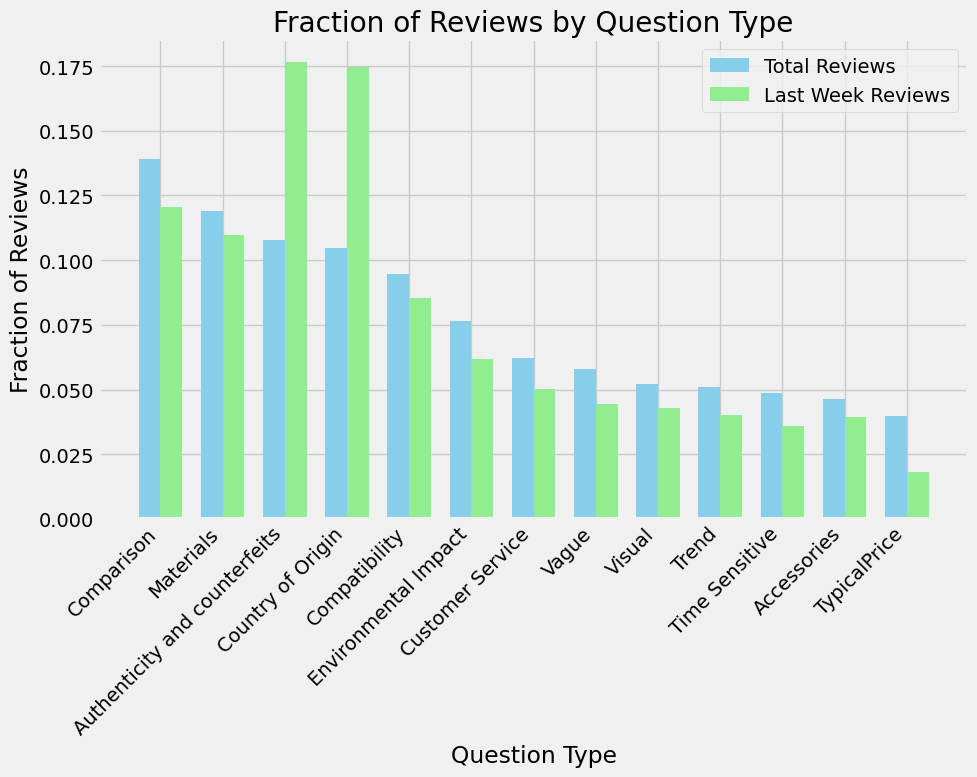

In [6]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

def plot_review_fractions(df):
    total_reviews = df['num_questions'].sum()
    total_reviews_last_week = df['num_in_last_week'].sum()

    df['fraction_reviews'] = df['num_questions'] / total_reviews
    df['fraction_reviews_last_week'] = df['num_in_last_week'] / total_reviews_last_week

    fig, ax = plt.subplots(figsize=(10, 8))

    width = 0.35
    x = range(len(df))

    ax.bar(x, df['fraction_reviews'], width, label='Total Reviews', color='skyblue')
    ax.bar([p + width for p in x], df['fraction_reviews_last_week'], width, label='Last Week Reviews', color='lightgreen')

    ax.set_xlabel('Question Type')
    ax.set_ylabel('Fraction of Reviews')
    ax.set_title('Fraction of Reviews by Question Type')
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels(df['question_type'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_review_fractions(cluster_stats)

# Conclusion

What areas would you prioritize?

Some candidates:
- Allow combining reviews across products since cross-product comparisons are both common and poorly served
- Include metadata filtering by review date or add other temporal data since `Time Sensitive` and `Trend` queries are poorly served. These do seem to be less popular at the moment.
- If you run a platform with many sellers (e.g. Amazon), allow filtering by seller within a given SKU. This may help address `Counterfeits`. It is common, poorly served, and seems to be getting more common right now.

The exact prioritization would depend on how much effort you thought each potential improvement requires, how effective you expect it to be, etc. But now you have a starting point to inform these decisions.